In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import seaborn as sns
import os

df = pd.read_csv('/content/tiktok_500_users.csv')
print(df.head())

  user_id  age  gender location        channel_name   category  \
0    U001   50  Female      HCM      @english_daily  Education   
1    U001   50  Female      HCM    @lienquan_mobile     Gaming   
2    U001   50  Female      HCM            @duytham       Tech   
3    U001   50  Female      HCM  @music_trending_vn      Music   
4    U001   50  Female      HCM            @khoapug     Travel   

   channel_followers  channel_total_likes  channel_total_shares  \
0            2085683             22029838                365666   
1            6454966             80971801               1836159   
2            5390827             61607220               1121879   
3            3625739             37471871                393496   
4            5137163             54857798               1496626   

   channel_total_reposts  user_rating  watch_time_sec  interaction_score  \
0                 146266            2              21              0.134   
1                 734463            5           

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                5029 non-null   object 
 1   age                    5029 non-null   int64  
 2   gender                 5029 non-null   object 
 3   location               5029 non-null   object 
 4   channel_name           5029 non-null   object 
 5   category               5029 non-null   object 
 6   channel_followers      5029 non-null   int64  
 7   channel_total_likes    5029 non-null   int64  
 8   channel_total_shares   5029 non-null   int64  
 9   channel_total_reposts  5029 non-null   int64  
 10  user_rating            5029 non-null   int64  
 11  watch_time_sec         5029 non-null   int64  
 12  interaction_score      5029 non-null   float64
 13  last_watch_date        5029 non-null   object 
dtypes: float64(1), int64(7), object(6)
memory usage: 550.2+ 

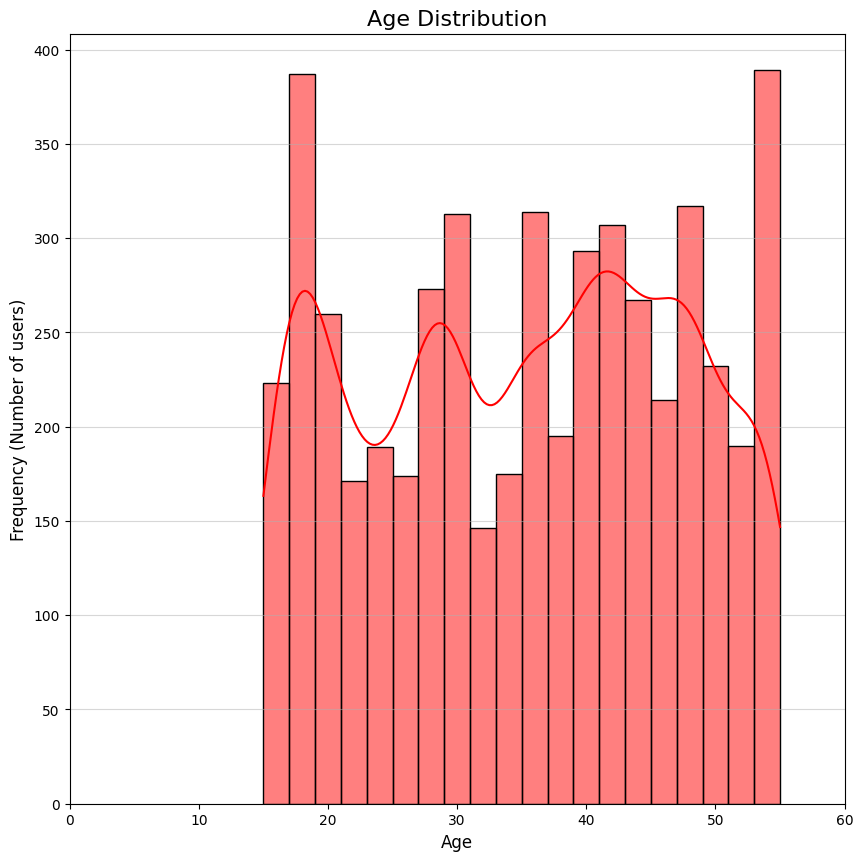

In [23]:


def create_age_distribution_chart(data_path, age_column='age'):

    if not os.path.exists(data_path):
        print(f"Error: The file '{data_path}' was not found. Please ensure the CSV file is uploaded to the /content/ directory.")
        return

    try:

        df = pd.read_csv(data_path)
    except Exception as e:
        print(f"Lỗi khi đọc file CSV: {e}")
        return

    if age_column not in df.columns:
        print(f"Lỗi: Cột '{age_column}' không tồn tại trong dữ liệu.")
        return


    df_clean = df.dropna(subset=[age_column])
    df_clean[age_column] = pd.to_numeric(df_clean[age_column], errors='coerce').astype('Int64')


    df_clean = df_clean[df_clean[age_column] > 0]


    plt.figure(figsize=(10, 10))


    sns.histplot(
        df_clean[age_column],
        bins=20,
        kde=True,
        color='Red',
        edgecolor='black'
    )

    plt.title('Age Distribution', fontsize=16)
    plt.xlabel('Age', fontsize=12)
    plt.ylabel('Frequency (Number of users)', fontsize=12)
    plt.grid(axis='y', alpha=0.5)
    plt.xlim(0, 60)
    plt.show()

file_path = "/content/tiktok_500_users.csv"
create_age_distribution_chart(file_path)

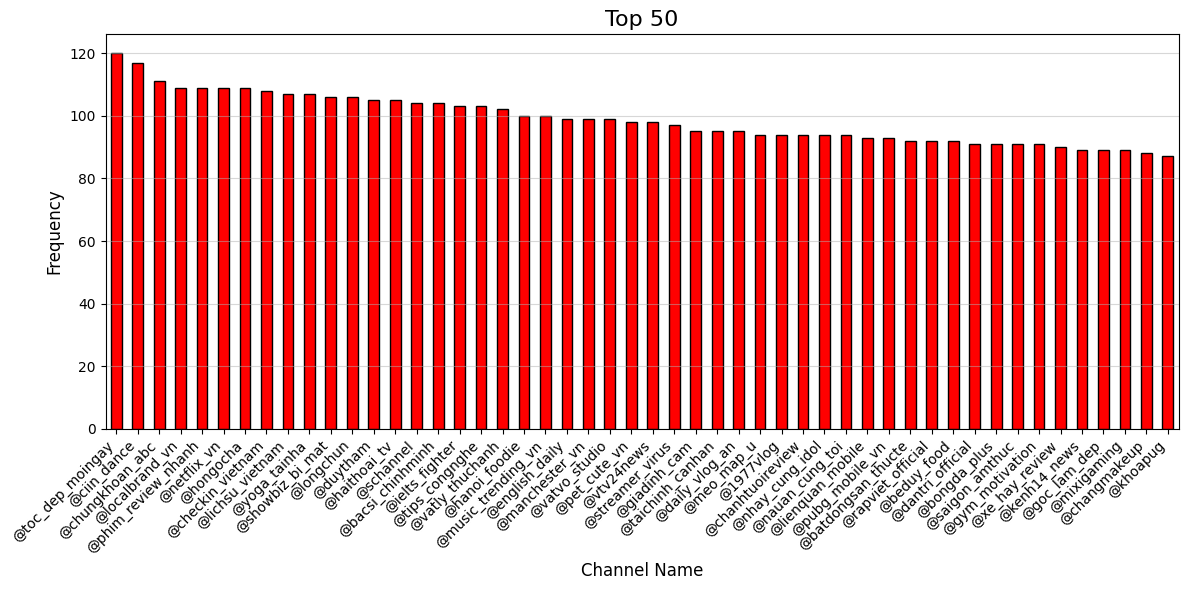

In [24]:


def plot_channel_frequency(data_path, channel_column='channel_name', top_n=10):
    try:
        df = pd.read_csv(data_path)
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file tại đường dẫn: {data_path}")
        return

    channel_counts = df[channel_column].value_counts().nlargest(top_n)

    plt.figure(figsize=(12, 6))
    channel_counts.plot(kind='bar', color='Red', edgecolor='black')

    plt.title(f'Top {top_n}', fontsize=16)
    plt.xlabel('Channel Name', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

file_path = "/content/tiktok_500_users.csv"
plot_channel_frequency(file_path, top_n=50)

In [25]:
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = [
    "channel_followers",
    "channel_total_likes",
    "channel_total_shares",
    "channel_total_reposts"
]
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

print("Min-Max scaling:", columns_to_scale)
print(df[columns_to_scale].head())



Min-Max scaling: ['channel_followers', 'channel_total_likes', 'channel_total_shares', 'channel_total_reposts']
   channel_followers  channel_total_likes  channel_total_shares  \
0           0.083010             0.039169              0.052869   
1           0.852745             0.613180              0.705671   
2           0.665276             0.424596              0.388577   
3           0.354321             0.189552              0.065223   
4           0.620588             0.358867              0.554940   

   channel_total_reposts  
0               0.052868  
1               0.705670  
2               0.388577  
3               0.065223  
4               0.554940  


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['category'].astype(str))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"category_tfidf_{t}" for t in tfidf_vectorizer.get_feature_names_out()])
df = pd.concat([df, tfidf_df], axis=1)

In [27]:
feature_cols = [
        'category',
        'channel_followers',
        'channel_total_likes',
        'channel_total_shares',
        'channel_total_reposts',
        'user_rating',
        'watch_time_sec',
        'interaction_score'
    ]

item_profiles = df[['channel_name'] + feature_cols].copy()

if item_profiles['category'].dtype == 'object':
    category_dummies = pd.get_dummies(item_profiles['category'], prefix='category')
    item_profiles = pd.concat([item_profiles.drop(columns=['category']), category_dummies], axis=1)

channel_vectors = {}
for idx, row in item_profiles.iterrows():
    channel_name = row['channel_name']
    channel_vectors[channel_name] = row.drop('channel_name').values

print("Numer of channel:", len(channel_vectors))
print("Vector for all channel:")
for k, v in channel_vectors.items():
    print(f"{k} : {v}")

Numer of channel: 51
Vector for all channel:
@english_daily : [0.08300957746578125 0.039168953901201675 0.05286856972386403
 0.05286814925962838 3 58 0.517 False False False False True False False
 False False False False False False False False False False False False
 False False]
@lienquan_mobile : [0.8527448560649502 0.6131797687072503 0.7056707268890068
 0.705670374258907 3 57 0.426 False False False False False False False
 False False True False False False False False False False False False
 False False]
@duytham : [0.6652758068792506 0.42459631555371813 0.38857739504729233
 0.38857690164855047 2 5 0.028 False False False False False False False
 False False False False False False False False False False False True
 False False]
@music_trending_vn : [0.3543207821230035 0.18955237334367753 0.06522325895659478
 0.06522284397703085 4 106 0.782 False False False False False False False
 False False False False False True False False False False False False
 False False]
@khoapug 

In [28]:
feature_cols = [
    'category',
    'channel_followers',
    'channel_total_likes',
    'channel_total_shares',
    'channel_total_reposts',
    'user_rating',
    'watch_time_sec',
    'interaction_score'
]

item_profiles = df[['channel_name'] + feature_cols].copy()

if item_profiles['category'].dtype == 'object':
    category_dummies = pd.get_dummies(item_profiles['category'], prefix='category')
    item_profiles = pd.concat([item_profiles.drop(columns=['category']), category_dummies], axis=1)

channel_vector_by_idx = {}
for idx, row in item_profiles.iterrows():
    vector = [
        float(x) if isinstance(x, float) or isinstance(x, int) else x
        for x in row.drop('channel_name').values.tolist()
    ]
    channel_vector_by_idx[idx] = vector

if 'user_id' not in df.columns:
    print("DataFrame thiếu user_id.")
else:
    user_profile_vectors = []
    for user_id, group in df.groupby('user_id'):
        channels_indices = group.index.tolist()
        channels_vectors = [channel_vector_by_idx[idx] for idx in group.index]
        if channels_vectors and len(channels_vectors) > 0:
            # Tính trung bình các vector của các kênh đã xem để ra vector đại diện cho user
            user_vector = np.mean(np.array(channels_vectors, dtype=float), axis=0)
        else:
            user_vector = None
        user_vec = {
            'user_id': user_id,
            'user_vector': user_vector
        }
        user_profile_vectors.append(user_vec)

    print("User Profile Vectors:")
    total_users_to_print = min(500, len(user_profile_vectors))
    for i, user_vec in enumerate(user_profile_vectors[:total_users_to_print]):
        print(f"\nUser {user_vec['user_id']}:")
        print(f"  User Vector: {user_vec['user_vector']}")

User Profile Vectors:

User U001:
  User Vector: [4.72470589e-01 4.43646007e-01 4.37721534e-01 4.37721255e-01
 3.06666667e+00 1.19800000e+02 4.85933333e-01 0.00000000e+00
 6.66666667e-02 6.66666667e-02 1.33333333e-01 6.66666667e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.33333333e-01 0.00000000e+00 0.00000000e+00 6.66666667e-02
 6.66666667e-02 6.66666667e-02 0.00000000e+00 0.00000000e+00
 6.66666667e-02 1.33333333e-01 1.33333333e-01 0.00000000e+00]

User U002:
  User Vector: [ 0.49270871  0.55531132  0.45888559  0.45888543  2.625      71.625
  0.5255      0.          0.          0.125       0.          0.
  0.          0.          0.          0.125       0.          0.
  0.125       0.125       0.          0.125       0.          0.
  0.125       0.          0.125       0.125     ]

User U003:
  User Vector: [ 0.28564976  0.37235391  0.37803596  0.37803577  2.5        50.91666667
  0.42975     0.          0.08333333  0.          0.          0.08333333
  0.083333

In [31]:

similarity_df = pd.DataFrame(
    similarity_matrix,
    index=user_ids,
    columns=item_ids)
print("COSINE SIMILARITY MATRIX")
from tabulate import tabulate
print(tabulate(similarity_df, headers='keys', tablefmt='grid'))

COSINE SIMILARITY MATRIX
+------+------------------+--------------------+------------+----------------------+------------+--------------------+----------------+----------------+-----------------+----------------+------------------+---------------+----------------+-------------------+-------------------+-------------------+---------------+-------------+----------------+-------------+----------------------+--------------------+-------------------+-------------------+--------------------+-------------------+------------------+--------------------+----------------------+-------------------+---------------------+----------------+------------------+----------------+--------------------+-------------+--------------------+------------------+------------------+------------------+-------------+--------------------+--------------+---------------+--------------+-------------------+-------------------+------------------+-----------------+----------------+---------------+
|      |   @english_daily |

In [30]:

user_vectors_for_similarity = []
user_ids_list = []

for user_data in user_profile_vectors:
    user_id = user_data['user_id']
    user_vector = user_data['user_vector']
    if user_vector is not None and len(user_vector) > 0: # Check if user_vector is not empty
        user_vectors_for_similarity.append(user_vector)
        user_ids_list.append(user_id)
    else:
        print(f"Warning: User {user_id} has no valid vector or an empty vector.")

user_ids = user_ids_list
item_ids = list(channel_vectors.keys()) # Use channel_vectors defined in previous cells

item_matrix_raw = np.array(list(channel_vectors.values()), dtype=float)
item_matrix = normalize(item_matrix_raw)

if len(user_vectors_for_similarity) == 0:
    print("Error: No valid user vectors found for similarity calculation.")
else:
    user_matrix = np.array(user_vectors_for_similarity, dtype=float)
    user_matrix = normalize(user_matrix)
    similarity_matrix = cosine_similarity(user_matrix, item_matrix)

    TOP_K = 5
    user_recommendations = {}

    for u_index, user_id in enumerate(user_ids):
        scores = similarity_matrix[u_index]
        sorted_item_indices = np.argsort(scores)[::-1]
        recommended_items = []
        for item_idx in sorted_item_indices:
            channel_name = item_ids[item_idx]
            recommended_items.append(channel_name)
            if len(recommended_items) == TOP_K:
                break
        user_recommendations[user_id] = recommended_items

    for u in list(user_ids)[:500]:
        print(f"\nUser {u} → Recommended channels:")
        for ch in user_recommendations[u]:
            print("   -", ch)



User U001 → Recommended channels:
   - @nhay_cung_idol
   - @bacsi_chinhminh
   - @ielts_fighter
   - @yoga_tainha
   - @longchun

User U002 → Recommended channels:
   - @hongocha
   - @1977vlog
   - @mixigaming
   - @ciin_dance
   - @vatvo_studio

User U003 → Recommended channels:
   - @meo_map_u
   - @manchester_vn
   - @goc_lam_dep
   - @1977vlog
   - @toc_dep_moingay

User U004 → Recommended channels:
   - @ielts_fighter
   - @yoga_tainha
   - @nhay_cung_idol
   - @showbiz_bi_mat
   - @nauan_cung_toi

User U005 → Recommended channels:
   - @fashion_week_vn
   - @ciin_dance
   - @1977vlog
   - @mixigaming
   - @toc_dep_moingay

User U006 → Recommended channels:
   - @lichsu_vietnam
   - @vatly_thuchanh
   - @pet_cute_vn
   - @showbiz_bi_mat
   - @chungkhoan_abc

User U007 → Recommended channels:
   - @hongocha
   - @mixigaming
   - @1977vlog
   - @ciin_dance
   - @bacsi_chinhminh

User U008 → Recommended channels:
   - @lichsu_vietnam
   - @pet_cute_vn
   - @vatly_thuchanh
   - @vt

In [32]:
if 'user_id' in df.columns and 'channel_name' in df.columns:
    precision_at_k_total = 0
    user_count = 0
    for u in user_ids:
        ground_truth = set(df[df['user_id'] == u]['channel_name'])
        recommended = set(user_recommendations[u][:TOP_K])
        if len(recommended) > 0:
            num_correct = len(ground_truth & recommended)
            precision = num_correct / len(recommended)
            precision_at_k_total += precision
            user_count += 1
            print(f"Precision for {u}: {precision:.3f} (Correct: {num_correct}, Recommended: {len(recommended)})")
    if user_count > 0:
        avg_precision_at_k = precision_at_k_total / user_count
        print(f"\n Model Precision {avg_precision_at_k:.3f}")
else:
    print("Không thể tính Precision vì thiếu user_id hoặc channel_name trong df.")

Precision for U001: 0.200 (Correct: 1, Recommended: 5)
Precision for U002: 0.400 (Correct: 2, Recommended: 5)
Precision for U003: 0.200 (Correct: 1, Recommended: 5)
Precision for U004: 0.200 (Correct: 1, Recommended: 5)
Precision for U005: 0.200 (Correct: 1, Recommended: 5)
Precision for U006: 0.000 (Correct: 0, Recommended: 5)
Precision for U007: 0.200 (Correct: 1, Recommended: 5)
Precision for U008: 0.000 (Correct: 0, Recommended: 5)
Precision for U009: 0.000 (Correct: 0, Recommended: 5)
Precision for U010: 0.200 (Correct: 1, Recommended: 5)
Precision for U011: 0.200 (Correct: 1, Recommended: 5)
Precision for U012: 0.000 (Correct: 0, Recommended: 5)
Precision for U013: 0.000 (Correct: 0, Recommended: 5)
Precision for U014: 0.600 (Correct: 3, Recommended: 5)
Precision for U015: 0.200 (Correct: 1, Recommended: 5)
Precision for U016: 0.400 (Correct: 2, Recommended: 5)
Precision for U017: 0.200 (Correct: 1, Recommended: 5)
Precision for U018: 0.200 (Correct: 1, Recommended: 5)
Precision 

In [33]:
recalls = []
for user_id in user_ids:
    recs = set(user_recommendations.get(user_id, []))
    gt_set = set(df[df['user_id'] == user_id]['channel_name'])
    if len(gt_set) > 0:
        recall = len(gt_set & recs) / len(gt_set)
        recalls.append(recall)
if recalls:
    avg_recall = sum(recalls) / len(recalls)
    print(f"\nModel Recall: {avg_recall:.4f}")
else:
    print("\nKhông tính được Recall.")


Model Recall: 0.1306


In [34]:
from math import sqrt
from sklearn.metrics import mean_squared_error

all_rmse = []
for idx, user_id in enumerate(user_ids):
    scores = similarity_matrix[idx]
    watched_set = set(df[df['user_id'] == user_id]['channel_name'])
    gt = np.array([1 if item_ids[i] in watched_set else 0 for i in range(len(item_ids))], dtype=float)
    preds = np.array(scores)
    if np.sum(gt) == 0:
        continue
    rmse = sqrt(mean_squared_error(gt, preds))
    all_rmse.append(rmse)
if all_rmse:
    avg_rmse = sum(all_rmse) / len(all_rmse)
    print(f"\nModel RMSE (trên user): {avg_rmse:.4f}")
else:
    print("\nKhông tính được RMSE.")


Model RMSE (trên user): 0.8887
